# 台灣銀行牌告匯率爬蟲練習
## 範例1： 練習爬取台幣對其他貨幣匯率資料

In [1]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

### 進入台灣銀行牌告匯率網頁：https://rate.bot.com.tw/xrt?Lang=zh-TW ，擷取當日台幣對美金的匯率資訊

In [2]:
# 進入台灣銀行牌告匯率網頁，查看當日匯率資料
url = "https://rate.bot.com.tw/xrt?Lang=zh-TW"
resp = requests.get(url)
resp.encoding = 'utf-8'
# print(resp.text)  # 如有需要，列印出網頁原始碼

html = BeautifulSoup(resp.text, "lxml")
rate_table = html.find(name='table', attrs={'title':'牌告匯率'}).find(name='tbody').find_all(name='tr')

# 查詢美金(也就是匯率表的第一個元素)對台幣的匯率
currency = rate_table[0].find(name='div', attrs={'class':'visible-phone print_hide'})
print(currency.get_text().replace(" ", ""))  # 去掉空白

buy_rate = rate_table[0].find(name='td', attrs={'data-table':'本行現金買入'})
sell_rate = rate_table[0].find(name='td', attrs={'data-table':'本行現金賣出'})
print("即時現金買入: %s, 即時現金賣出: %s" % (buy_rate.get_text(), sell_rate.get_text()))


美金(USD)

即時現金買入: 29.74, 即時現金賣出: 30.41


### 作業part 1：請參考上面的範例，試著爬取所有貨幣對台幣的匯率

In [3]:
for table in rate_table:
  c = table.find(name='div', attrs={'class':'visible-phone print_hide'})
  
  buy_rate = table.find(name='td', attrs={'data-table':'本行現金買入'}).string
  sell_rate = table.find(name='td', attrs={'data-table':'本行現金賣出'}).string
  print(c.string.strip(), buy_rate, sell_rate, sep="\t")

美金 (USD)	29.74	30.41
港幣 (HKD)	3.723	3.927
英鎊 (GBP)	37.84	39.96
澳幣 (AUD)	19.85	20.63
加拿大幣 (CAD)	22.19	23.1
新加坡幣 (SGD)	21.39	22.3
瑞士法郎 (CHF)	30.31	31.51
日圓 (JPY)	0.2675	0.2803
南非幣 (ZAR)	-	-
瑞典幣 (SEK)	2.74	3.26
紐元 (NZD)	19.01	19.86
泰幣 (THB)	0.8499	1.0379
菲國比索 (PHP)	0.5202	0.6532
印尼幣 (IDR)	0.00188	0.00258
歐元 (EUR)	32.49	33.83
韓元 (KRW)	0.02363	0.02753
越南盾 (VND)	0.00092	0.00142
馬來幣 (MYR)	6.21	7.854
人民幣 (CNY)	4.212	4.374


## 範例2：爬取一個月的美金對台幣歷史匯率資料，並畫出趨勢圖


美金(USD)



<Figure size 720x576 with 0 Axes>

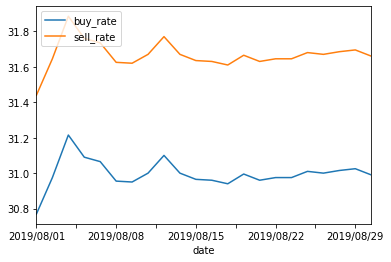

In [4]:
# 先到牌告匯率首頁，爬取所有貨幣的種類
url = "https://rate.bot.com.tw/xrt?Lang=zh-TW"
resp = requests.get(url)
resp.encoding = 'utf-8'
html = BeautifulSoup(resp.text, "lxml")
rate_table = html.find(name='table', attrs={'title':'牌告匯率'}).find(name='tbody').find_all(name='tr')

# 擷取匯率表格，把美金(也就是匯率表的第一個元素)擷取出來，查詢其歷史匯率
currency = rate_table[0].find(name='div', attrs={'class':'visible-phone print_hide'})
print(currency.get_text().replace(" ", ""))  # 貨幣種類

# 針對美金，找到其「歷史匯率」的首頁 
history_link = rate_table[0].find(name='td', attrs={'data-table':'歷史匯率'})
history_rate_link = "https://rate.bot.com.tw" + history_link.a["href"]  # 該貨幣的歷史資料首頁

#
# 到貨幣歷史匯率網頁，選則該貨幣的「歷史區間」，送出查詢後，觀察其網址變化情形，再試著抓取其歷史匯率資料
#
# 用「quote/年-月」去取代網址內容，就可以連到該貨幣的歷史資料
quote_history_url = history_rate_link.replace("history", "quote/2019-08")
resp = requests.get(quote_history_url)
resp.encoding = 'utf-8'
history = BeautifulSoup(resp.text, "lxml")
history_table = history.find(name='table', attrs={'title':'歷史本行營業時間牌告匯率'}).find(name='tbody').find_all(name='tr')

#
# 擷取到歷史匯率資料後，把資料彙整起來並畫出趨勢圖
#
date_history = list()
history_buy = list()
history_sell = list()

for history_rate in history_table:
    # 擷取日期資料
    date_string = history_rate.a.get_text()
    date = datetime.strptime(date_string, '%Y/%M/%d').strftime('%Y/%M/%d')  # 轉換日期格式
    date_history.append(date)  # 日期歷史資料

    history_ex_rate = history_rate.find_all(name='td', attrs={'class':'rate-content-cash text-right print_table-cell'})
    history_buy.append(float(history_ex_rate[0].get_text()))  # 歷史買入匯率
    history_sell.append(float(history_ex_rate[1].get_text()))  # 歷史賣出匯率

# 將匯率資料建成dataframe形式
HistoryExchangeRate = pd.DataFrame({'date': date_history,
                                    'buy_rate':history_buy,
                                    'sell_rate':history_sell})

HistoryExchangeRate = HistoryExchangeRate.set_index('date')  # 指定日期欄位為datafram的index
HistoryExchangeRate = HistoryExchangeRate.sort_index(ascending=True)

# 畫出歷史匯率軌跡圖
plt.figure(figsize=(10, 8))
HistoryExchangeRate[['buy_rate','sell_rate']].plot()  # x=['date'], y=[['buy_rate','sell_rate']] 
plt.legend(loc="upper left")
plt.show()

### 作業part 2：爬取每種貨幣對台幣的一個月歷史匯率資料，並畫出趨勢圖


美金(USD)



<Figure size 720x576 with 0 Axes>

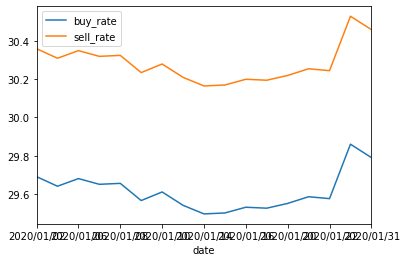


港幣(HKD)



<Figure size 720x576 with 0 Axes>

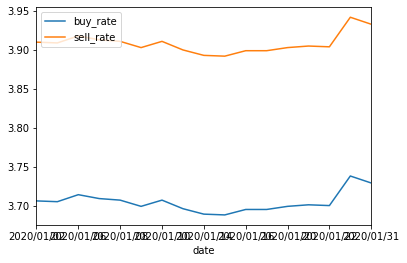


英鎊(GBP)



<Figure size 720x576 with 0 Axes>

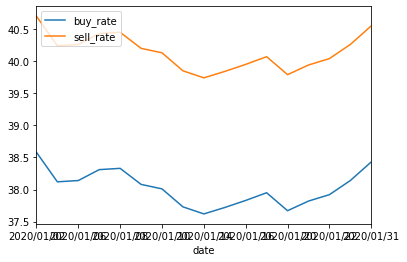


澳幣(AUD)



<Figure size 720x576 with 0 Axes>

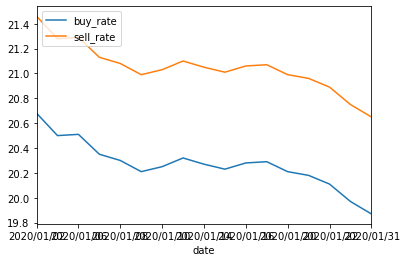


加拿大幣(CAD)



<Figure size 720x576 with 0 Axes>

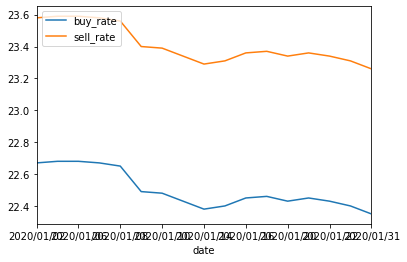


新加坡幣(SGD)



<Figure size 720x576 with 0 Axes>

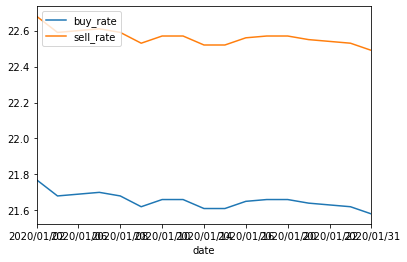


瑞士法郎(CHF)



<Figure size 720x576 with 0 Axes>

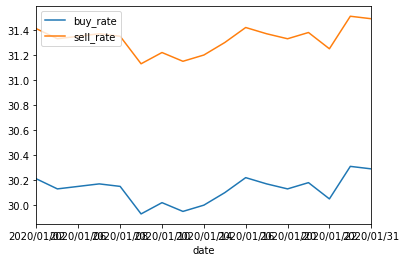


日圓(JPY)



<Figure size 720x576 with 0 Axes>

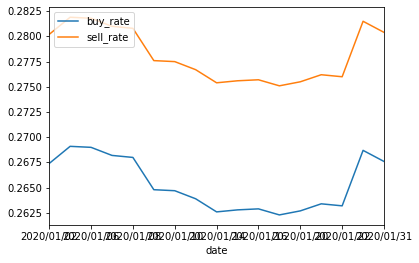


南非幣(ZAR)



<Figure size 720x576 with 0 Axes>

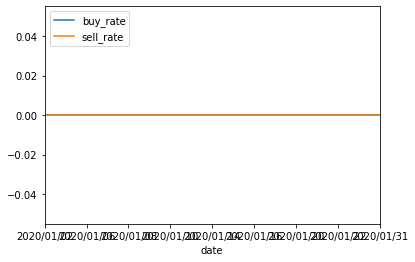


瑞典幣(SEK)



<Figure size 720x576 with 0 Axes>

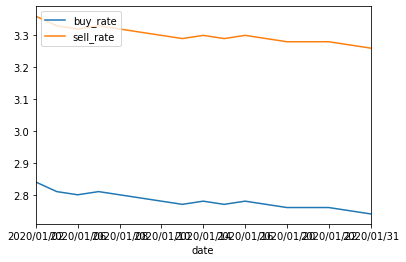


紐元(NZD)



<Figure size 720x576 with 0 Axes>

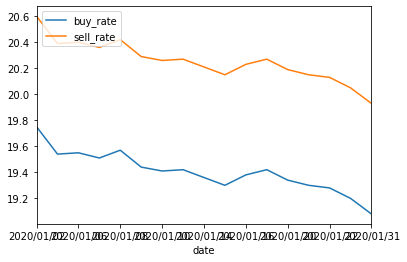


泰幣(THB)



<Figure size 720x576 with 0 Axes>

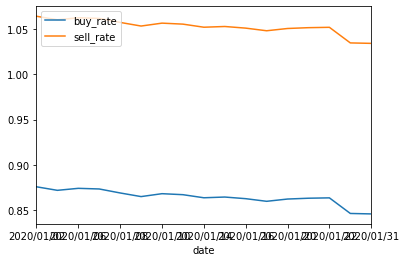


菲國比索(PHP)



<Figure size 720x576 with 0 Axes>

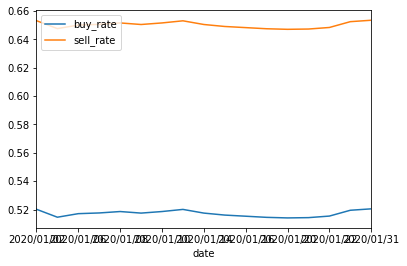


印尼幣(IDR)



<Figure size 720x576 with 0 Axes>

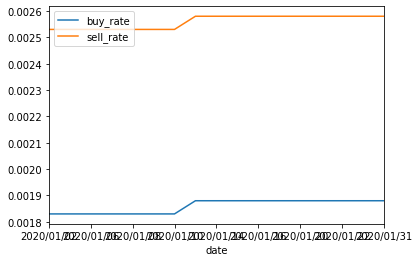


歐元(EUR)



<Figure size 720x576 with 0 Axes>

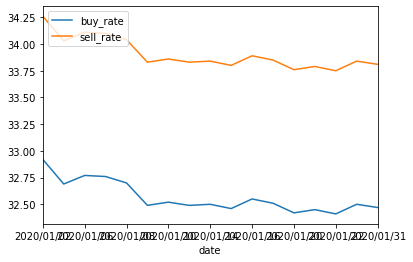


韓元(KRW)



<Figure size 720x576 with 0 Axes>

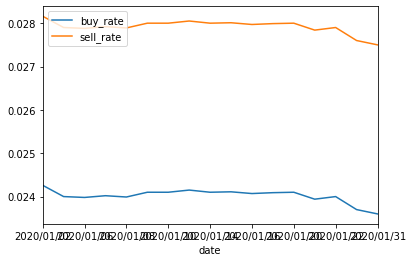


越南盾(VND)



<Figure size 720x576 with 0 Axes>

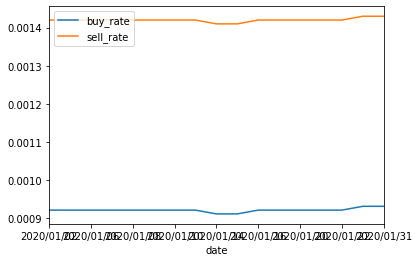


馬來幣(MYR)



<Figure size 720x576 with 0 Axes>

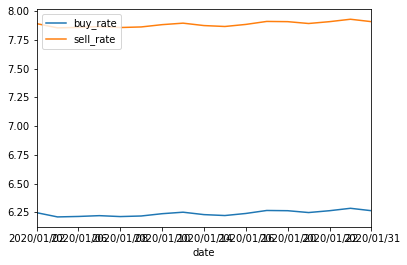


人民幣(CNY)



<Figure size 720x576 with 0 Axes>

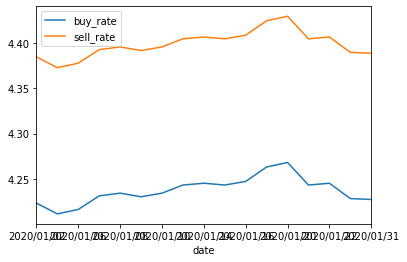

In [5]:
url = "https://rate.bot.com.tw/xrt?Lang=zh-TW"
resp = requests.get(url)
resp.encoding = 'utf-8'
html = BeautifulSoup(resp.text, "lxml")
rate_table = html.find(name='table', attrs={'title':'牌告匯率'}).find(name='tbody').find_all(name='tr')

# 擷取匯率表格，把美金(也就是匯率表的第一個元素)擷取出來，查詢其歷史匯率
for table in rate_table:
  currency = table.find(name='div', attrs={'class':'visible-phone print_hide'})
  print(currency.get_text().replace(" ", ""))  # 貨幣種類

  # 針對美金，找到其「歷史匯率」的首頁 
  history_link = table.find(name='td', attrs={'data-table':'歷史匯率'})
  history_rate_link = "https://rate.bot.com.tw" + history_link.a["href"]  # 該貨幣的歷史資料首頁

  #
  # 到貨幣歷史匯率網頁，選則該貨幣的「歷史區間」，送出查詢後，觀察其網址變化情形，再試著抓取其歷史匯率資料
  #
  # 用「quote/年-月」去取代網址內容，就可以連到該貨幣的歷史資料
  quote_history_url = history_rate_link.replace("history", "quote/2020-01")
  resp = requests.get(quote_history_url)
  resp.encoding = 'utf-8'
  history = BeautifulSoup(resp.text, "lxml")
  history_table = history.find(name='table', attrs={'title':'歷史本行營業時間牌告匯率'}).find(name='tbody').find_all(name='tr')

#
# 擷取到歷史匯率資料後，把資料彙整起來並畫出趨勢圖
#
  date_history = list()
  history_buy = list()
  history_sell = list()

  for history_rate in history_table:
      # 擷取日期資料
      date_string = history_rate.a.get_text()
      date = datetime.strptime(date_string, '%Y/%M/%d').strftime('%Y/%M/%d')  # 轉換日期格式
      date_history.append(date)  # 日期歷史資料

      history_ex_rate = history_rate.find_all(name='td', attrs={'class':'rate-content-cash text-right print_table-cell'})
      history_buy.append(float(history_ex_rate[0].get_text()))  # 歷史買入匯率
      history_sell.append(float(history_ex_rate[1].get_text()))  # 歷史賣出匯率

  # 將匯率資料建成dataframe形式
  HistoryExchangeRate = pd.DataFrame({'date': date_history,
                                      'buy_rate':history_buy,
                                      'sell_rate':history_sell})

  HistoryExchangeRate = HistoryExchangeRate.set_index('date')  # 指定日期欄位為datafram的index
  HistoryExchangeRate = HistoryExchangeRate.sort_index(ascending=True)

  # 畫出歷史匯率軌跡圖
  plt.figure(figsize=(10, 8))
  HistoryExchangeRate[['buy_rate','sell_rate']].plot()  # x=['date'], y=[['buy_rate','sell_rate']] 
  plt.legend(loc="upper left")
  plt.show()